In [1]:
# 필요한 라이브러리를 import합니다.
import sys
# 파이토치
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from torch.utils.data import Dataset, DataLoader 
#!pip install -q sktime
from tqdm import tqdm
import xgboost as xgb
import pandas as pd
import numpy as np
from datetime import datetime
import math
import os
from xgboost import XGBRegressor
import platform
import optuna
from sktime.forecasting.model_selection import temporal_train_test_split

device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')

# 랜덤 시드를 설정합니다. 이렇게 하면 코드를 다시 실행할 때도 같은 결과를 얻을 수 있습니다.
np.random.seed(42)

# 현재 사용하고 있는 라이브러리의 버전을 출력합니다.
print("Python version:", sys.version)
print("xgboost version:", xgb.__version__)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("optuna version:", optuna.__version__)

Python version: 3.10.9 (main, Mar  1 2023, 12:20:14) [Clang 14.0.6 ]
xgboost version: 2.0.0
pandas version: 1.5.3
numpy version: 1.22.3
optuna version: 3.3.0


# 데이터 기본 관찰

In [2]:
# 데이터 로드
train_data = pd.read_csv('open/train.csv')
test_data = pd.read_csv('open/test.csv')
build_data = pd.read_csv('open/building_info.csv')

In [3]:
train_data.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [4]:
test_data.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77


In [6]:
# 한글은 깨짐현상이 있어 컬럼이름 영어로 변경
train_data = train_data.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test_data = test_data.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
build_data = build_data.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data Center',
    '백화점및아울렛': 'Department Store and Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    '지식산업센터': 'Knowledge Industry Center',
    '할인마트': 'Discount Mart',
    '호텔및리조트': 'Hotel and Resort'
}

build_data['building_type'] = build_data['building_type'].replace(translation_dict)

- test에는 train.csv와 다르게 `일조, 일사, 전력소비량`컬럼이 없는 상태

In [7]:
# 각 데이터의 결측치 확인
train_missing = train_data.isnull().sum()
test_missing = test_data.isnull().sum()

print("train.csv의 결측치:\n", train_missing)
print("\ntest.csv의 결측치:\n", test_missing)

train.csv의 결측치:
 num_date_time             0
building_number           0
date_time                 0
temperature               0
rainfall             160069
windspeed                19
humidity                  9
sunshine              75182
solar_radiation       87913
power_consumption         0
dtype: int64

test.csv의 결측치:
 num_date_time      0
building_number    0
date_time          0
temperature        0
rainfall           0
windspeed          0
humidity           0
dtype: int64


- 결측치는 train에서만 발견됨

In [8]:
build_data.head()

,building_number,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,Other Buildings,110634.00,39570.00,-,-,-
1,2,Other Buildings,122233.47,99000.00,-,-,-
2,3,Other Buildings,171243.00,113950.00,40,-,-
3,4,Other Buildings,74312.98,34419.62,60,-,-
4,5,Other Buildings,205884.00,150000.00,-,2557,1000


- 건물유형: 상업용, 주거용, 공장 등의 건물 유형에 따라 전력 소비량이 다를 수 있습니다.
- 연면적: 큰 건물은 전력 사용량이 많을 가능성이 높을 수 있습니다.
- 냉방면적: 냉방면적도 냉방 운영과 관련이 있어서 전력 소비량에 영향을 줄 수 있습니다

In [9]:
train_df = pd.merge(train_data, build_data, on = 'building_number', how = 'left')
test_df = pd.merge(test_data, build_data, on = 'building_number', how = 'left')

 - building_info의 태양광, ESS, PCS는 사용하지 않을 것이라 drop

In [10]:
train_df = train_df.drop(['solar_power_capacity', 'ess_capacity', 'pcs_capacity'], axis = 1)
test_df = test_df.drop(['solar_power_capacity', 'ess_capacity', 'pcs_capacity'], axis = 1)

# 탐색적 데이터 분석(EDA)

In [11]:
# 전부 22년임으로 year은 제외한 후 생성
train_df['date'] = pd.to_datetime(train_df['date_time'], format = '%Y%m%d %H')

train_df['hour'] = train_df['date'].dt.hour
train_df['day'] = train_df['date'].dt.day
train_df['month'] = train_df['date'].dt.month
train_df['week'] = train_df['date'].dt.weekday
test_df['date'] = pd.to_datetime(test_df['date_time'], format='%Y%m%d %H')

test_df['hour'] = test_df['date'].dt.hour
test_df['day'] = test_df['date'].dt.day
test_df['month'] = test_df['date'].dt.month
test_df['week'] = test_df['date'].dt.dayofweek #요일

In [12]:
# 건물유형 확인
train_df['building_type'].unique()

array(['Other Buildings', 'Public', 'University', 'Data Center',
       'Department Store and Outlet', 'Hospital', 'Commercial',
       'Apartment', 'Research Institute', 'Knowledge Industry Center',
       'Discount Mart', 'Hotel and Resort'], dtype=object)

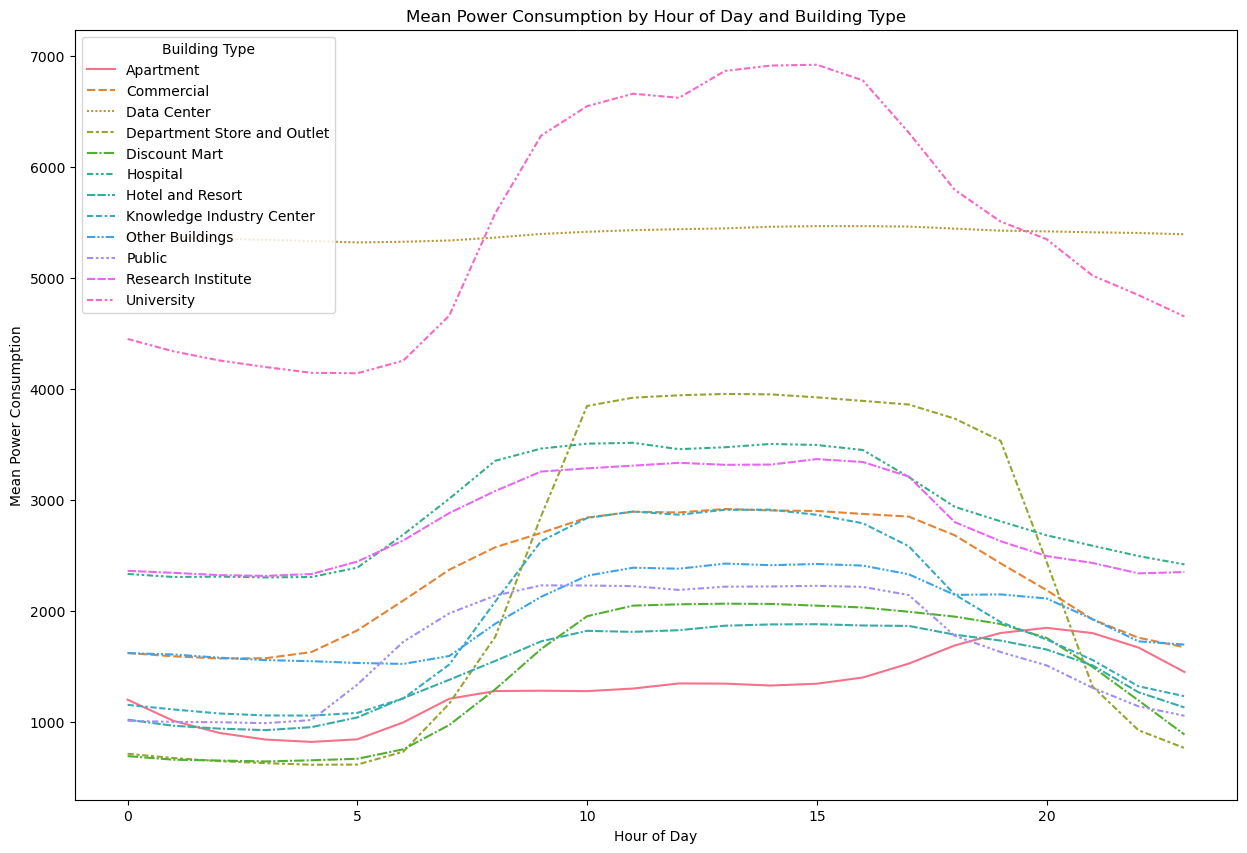

In [13]:
import seaborn as sns

# hour of the day
mean_power_by_hour_building = train_df.groupby(['hour', 'building_type'])['power_consumption'].mean().reset_index()

pivot_df = mean_power_by_hour_building.pivot(index='hour', columns='building_type', values='power_consumption')

plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Hour of Day and Building Type')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Type')
plt.show()

**낮시간에 전력을 가장 많이 소모, dataDenter와 Apartment만 조금 예외**

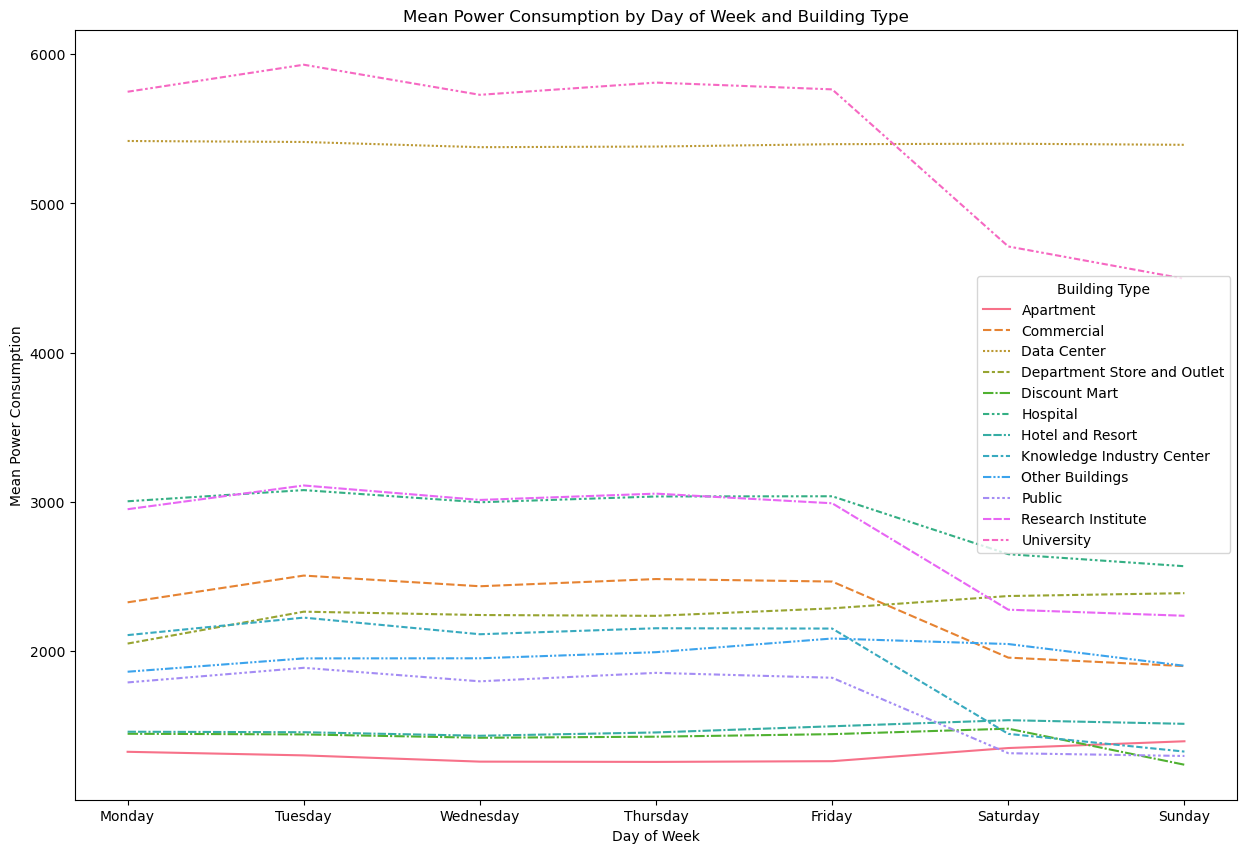

In [19]:
mean_power_by_day_building = train_df.groupby(['week', 'building_type'])['power_consumption'].mean().reset_index()

pivot_df_day = mean_power_by_day_building.pivot(index='week', columns='building_type', values='power_consumption')

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_df_day.index = day_names

plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df_day)
plt.title('Mean Power Consumption by Day of Week and Building Type')
plt.xlabel('Day of Week')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Type')
plt.show()

**주말엔 전력소비가 대체로 낮아지는 추세를 보임, datacenter, apartment, hotel and resort, department and outlet제외**

# 전처리 코드 분석

1. 결측치 처리
```
# 데이터 전처리 및 특성 추가
def process_data(data, mode):
    # 결측치 대체
    data['wind'] = data['wind'].fillna(method='ffill')
    data['hum'] = data['hum'].fillna(method='ffill')
    data = data.fillna(0)

    # 특성 추가
    data = time_features(data, mode)
    data = side_indicator(data)
    data = temp_features(data)

    # 주기적인 날짜 패턴을 코사인과 사인 함수로 변환
    data['summer_cos'] = data['date'].apply(summer_cos)
    data['summer_sin'] = data['date'].apply(summer_sin)

    return data
```

-> 시계열 데이터의 경우, 이전 시간대의 데이터로 결측치를 채우는 것이 좀 더 올바른 방법


- 🎯 time_features() 코드에 특정한 건물들에 대하여 처리한 부분에 대하여, 왜 그렇게 처리했는지, 어떠한 데이터 탐색을 통하여 그러한 처리를 했는지 그 근거를 알 수 있는 시각화 결과를 제출 해 보아요

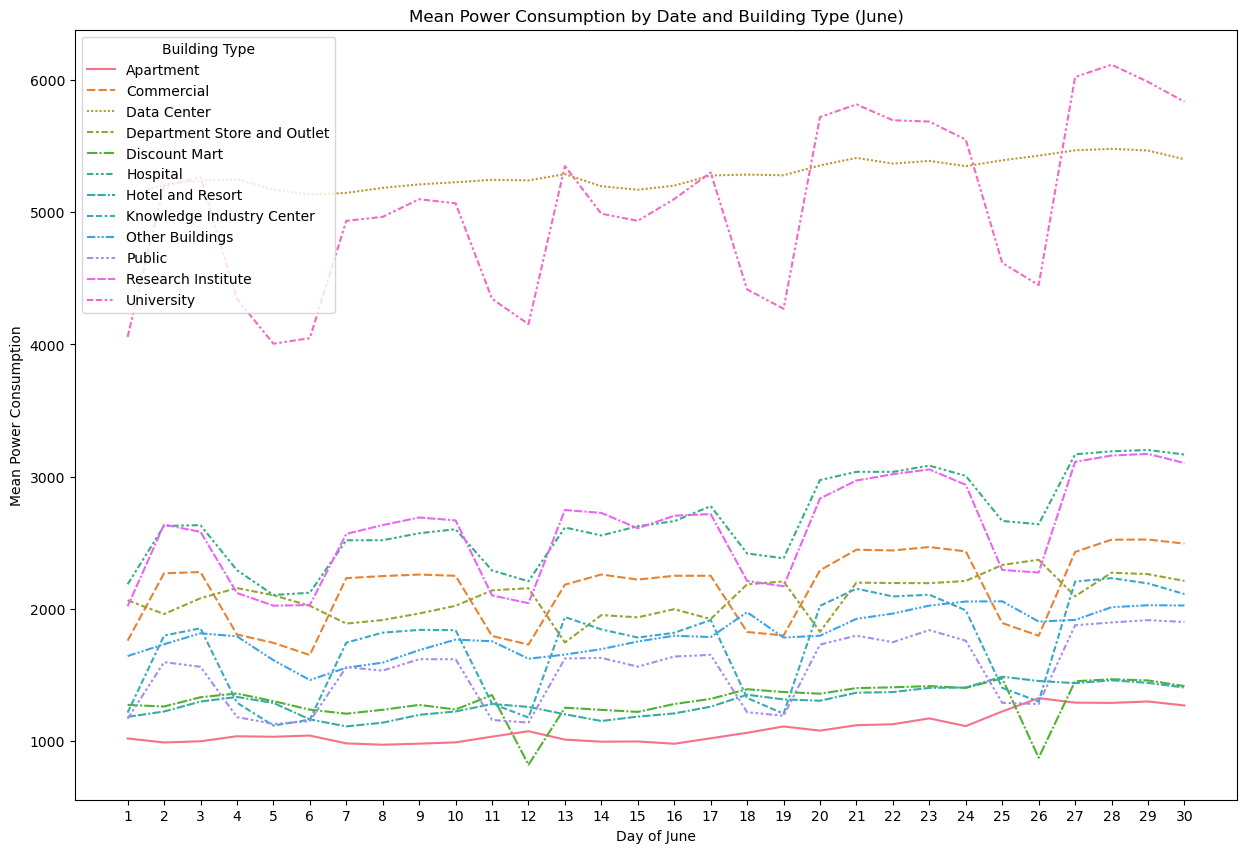

In [25]:
# 우선 데이터는 6~8월까지 정보만 있어 그 사이만 확인

# 6월 데이터 추출
june_data = train_df[train_df['month'] == 6]

# 건물 타입별 날짜별 평균 전력 소비량 계산
mean_power_by_date_building_type = june_data.groupby(['day', 'building_type'])['power_consumption'].mean().reset_index()

# Pivot 테이블 생성
pivot_df = mean_power_by_date_building_type.pivot(index='day', columns='building_type', values='power_consumption')

# 그래프 그리기
plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Date and Building Type (June)')
plt.xlabel('Day of June')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Type')
plt.xticks(range(1, 31))  # 6월은 30일까지 있으므로 범위를 1부터 30까지로 설정
plt.show()

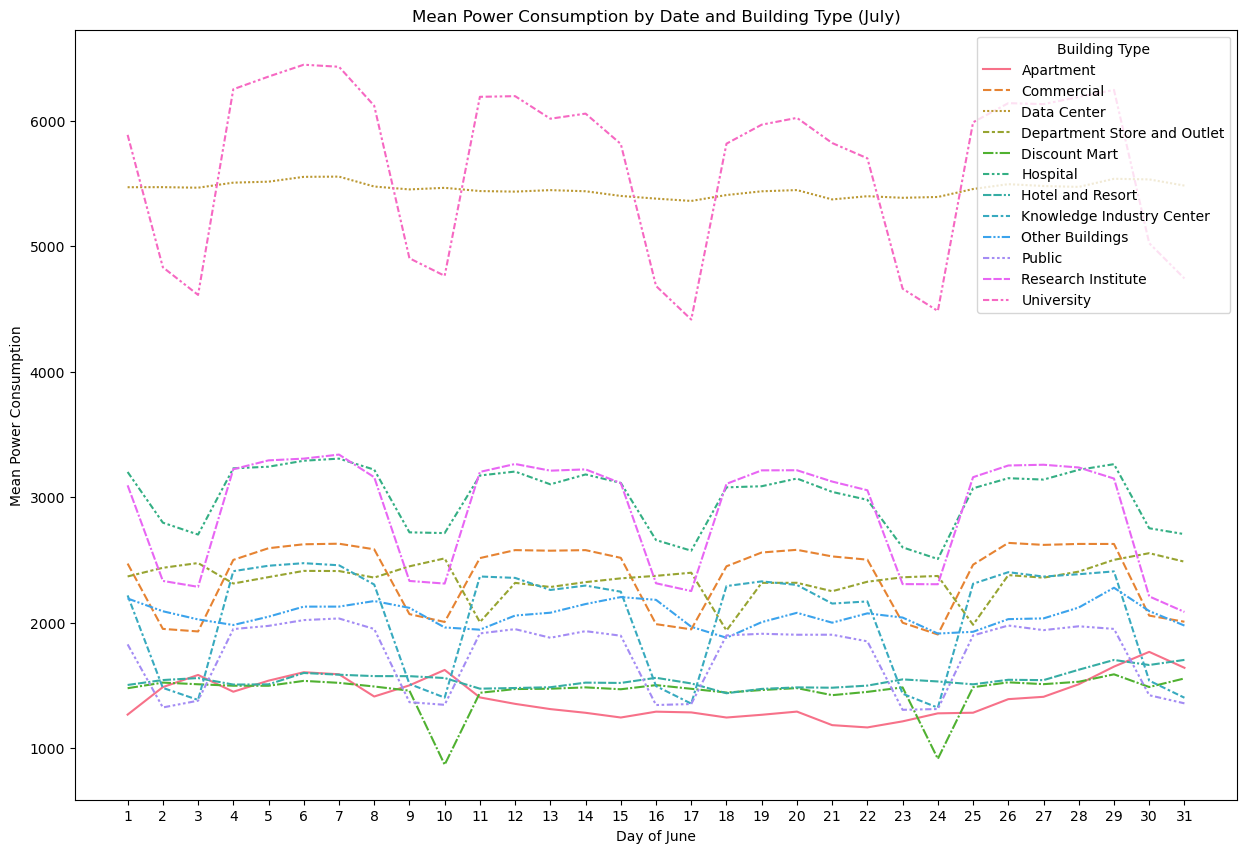

In [26]:
# 7월 데이터 추출
July_data = train_df[train_df['month'] == 7]

# 건물 타입별 날짜별 평균 전력 소비량 계산
mean_power_by_date_building_type = July_data.groupby(['day', 'building_type'])['power_consumption'].mean().reset_index()

# Pivot 테이블 생성
pivot_df = mean_power_by_date_building_type.pivot(index='day', columns='building_type', values='power_consumption')

# 그래프 그리기
plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Date and Building Type (July)')
plt.xlabel('Day of June')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Type')
plt.xticks(range(1, 32))  # 7월은 31일까지 있으므로 범위를 1부터 31까지로 설정
plt.show()

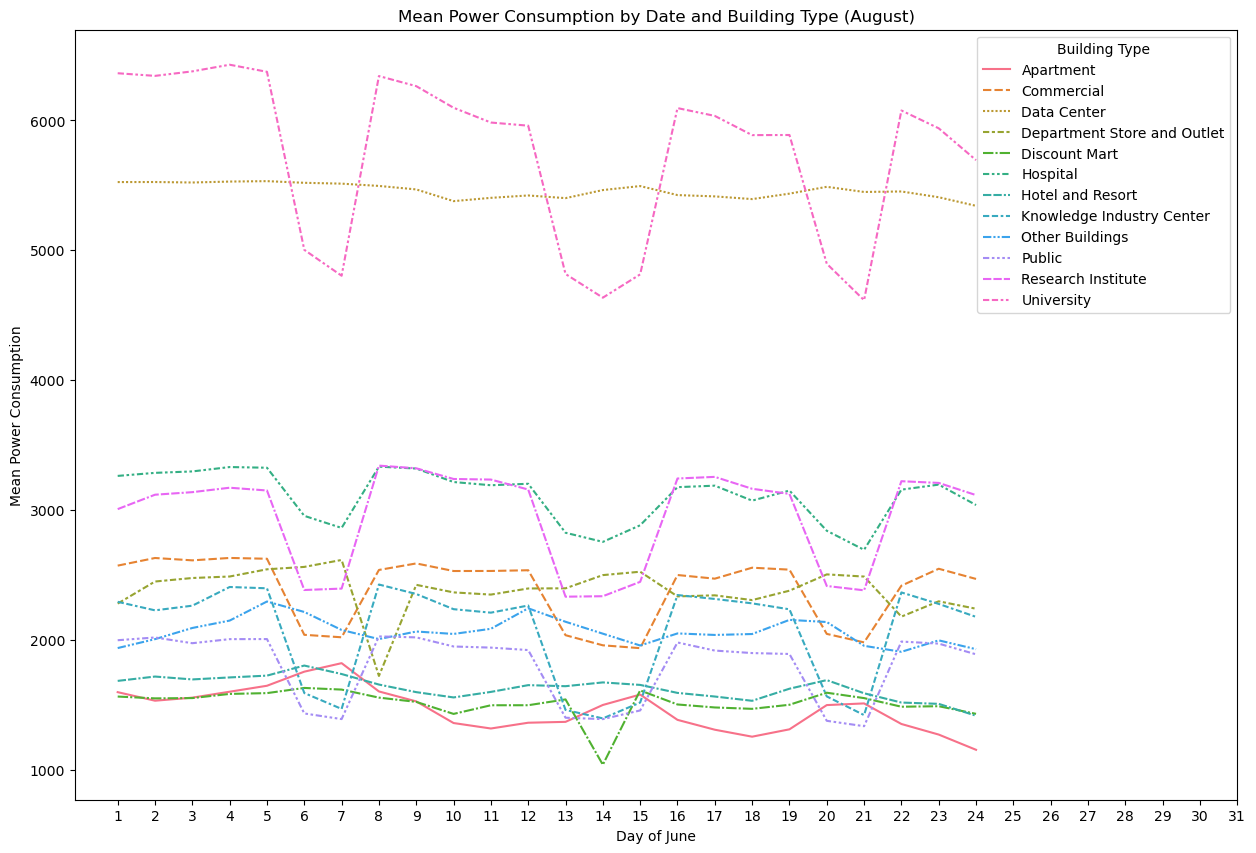

In [27]:
# 8월 데이터 추출
Aug_data = train_df[train_df['month'] == 8]

# 건물 타입별 날짜별 평균 전력 소비량 계산
mean_power_by_date_building_type = Aug_data.groupby(['day', 'building_type'])['power_consumption'].mean().reset_index()

# Pivot 테이블 생성
pivot_df = mean_power_by_date_building_type.pivot(index='day', columns='building_type', values='power_consumption')

# 그래프 그리기
plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Date and Building Type (August)')
plt.xlabel('Day of June')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Type')
plt.xticks(range(1, 32))   # 8월은 31일까지 있으므로 범위를 1부터 31까지로 설정
plt.show()

 - 그래프를 보면 아파트나 데이터센터 호텔 리조트를 제외한 빌딩 타입에서 이상치 발견, 공통으로 발견되는 이상치는 공휴일로 추측하고 그 외의 이상치는 빌딩 타입별 휴무날짜로 파악

제일 이상치가 심한 2개 빌딩 정보를 시각화(Discount Mart, Department Store and Outlet)

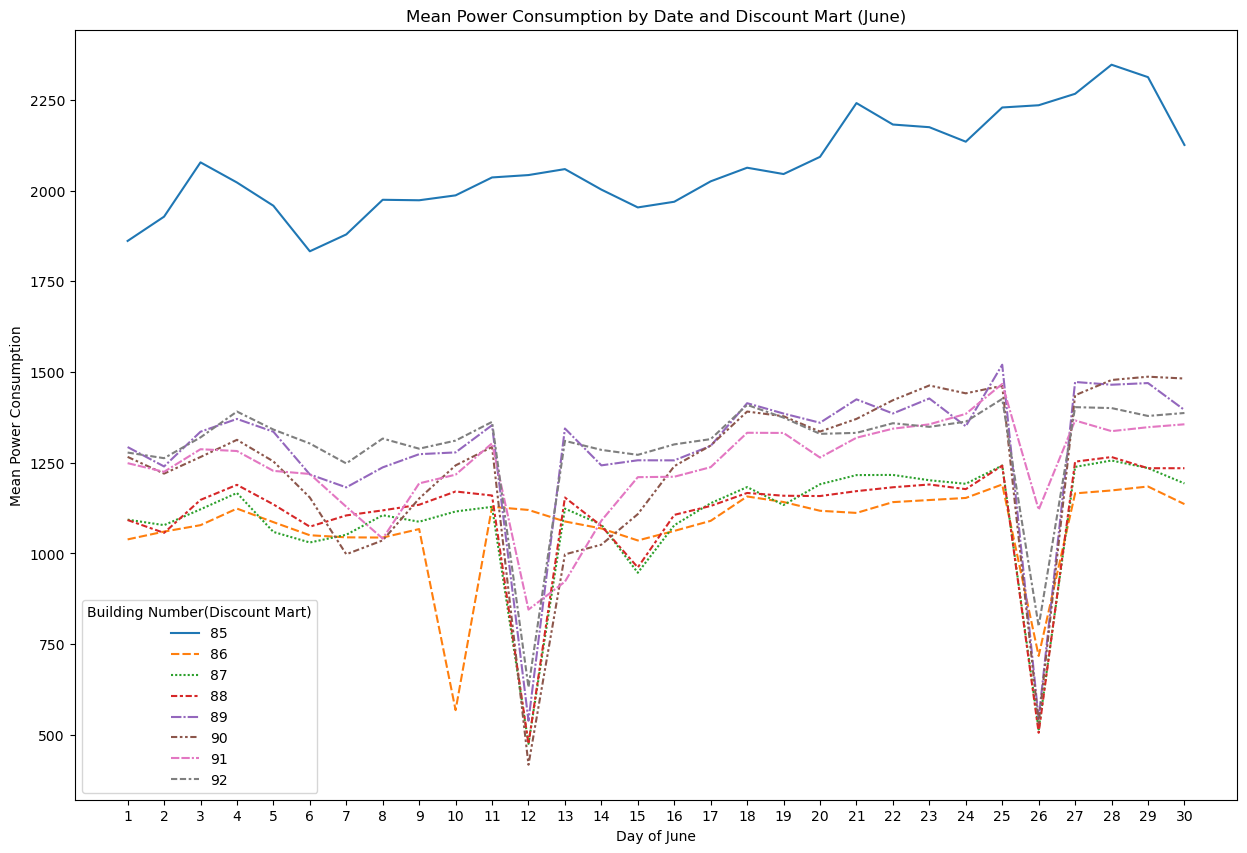

In [35]:
# Discount Mart (6월) 데이터

# 필요한 데이터 추출 (6월 데이터)
june_data = train_df[(train_df['month'] == 6) & (train_df['building_number'].between(85, 92))]

# 건물 번호별 날짜별 평균 전력 소비량 계산
mean_power_by_date_building_number = june_data.groupby(['day', 'building_number'])['power_consumption'].mean().reset_index()

# Pivot 테이블 생성
pivot_df = mean_power_by_date_building_number.pivot(index='day', columns='building_number', values='power_consumption')

# 그래프 그리기
plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Date and Discount Mart (June)')
plt.xlabel('Day of June')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Number(Discount Mart)')
plt.xticks(range(1, 31))  # 6월은 30일까지 있으므로 범위를 1부터 30까지로 설정
plt.show()

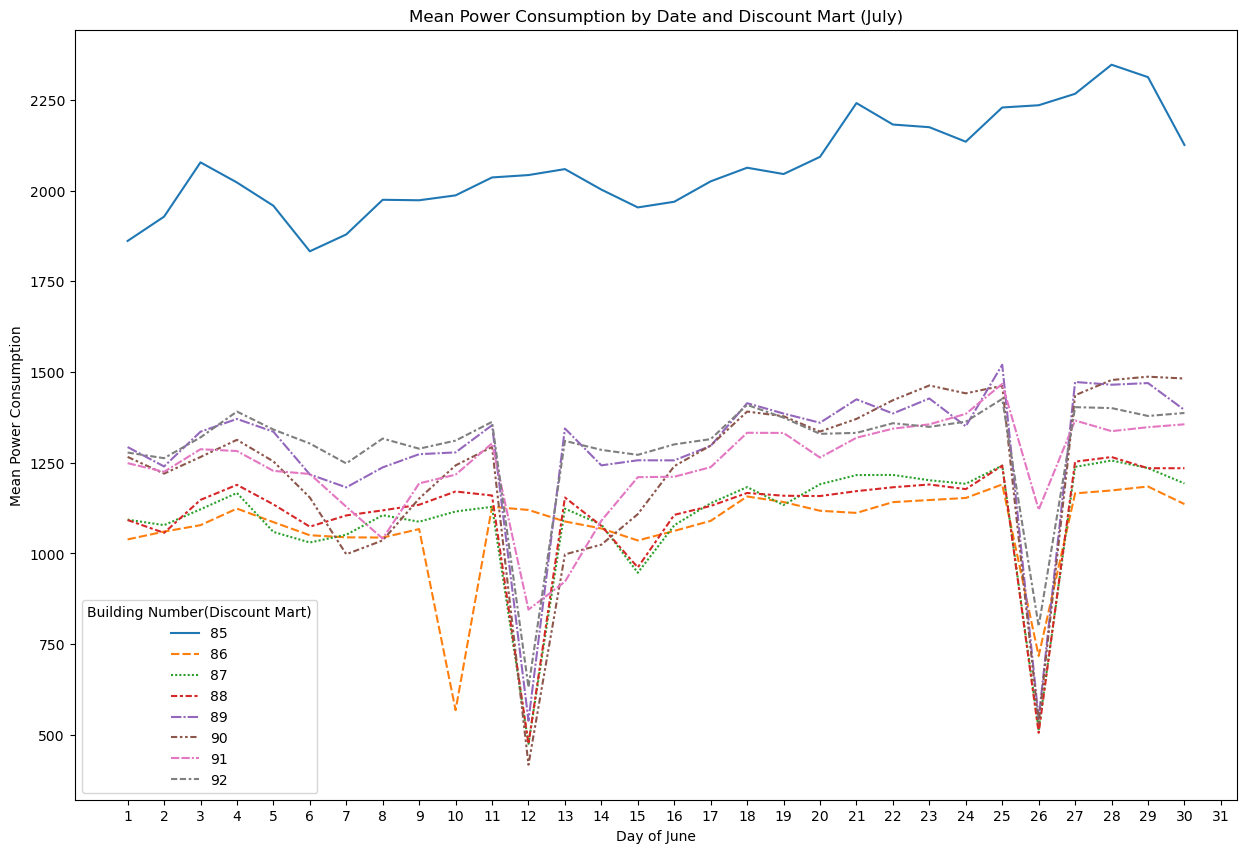

In [37]:
# Discount Mart (7월) 데이터

# 필요한 데이터 추출 (7월 데이터)
July_data = train_df[(train_df['month'] == 7) & (train_df['building_number'].between(85, 92))]

# 건물 번호별 날짜별 평균 전력 소비량 계산
mean_power_by_date_building_number = june_data.groupby(['day', 'building_number'])['power_consumption'].mean().reset_index()

# Pivot 테이블 생성
pivot_df = mean_power_by_date_building_number.pivot(index='day', columns='building_number', values='power_consumption')

# 그래프 그리기
plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Date and Discount Mart (July)')
plt.xlabel('Day of June')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Number(Discount Mart)')
plt.xticks(range(1, 32))  # 7월은 31일까지 있으므로 범위를 1부터 30까지로 설정
plt.show()

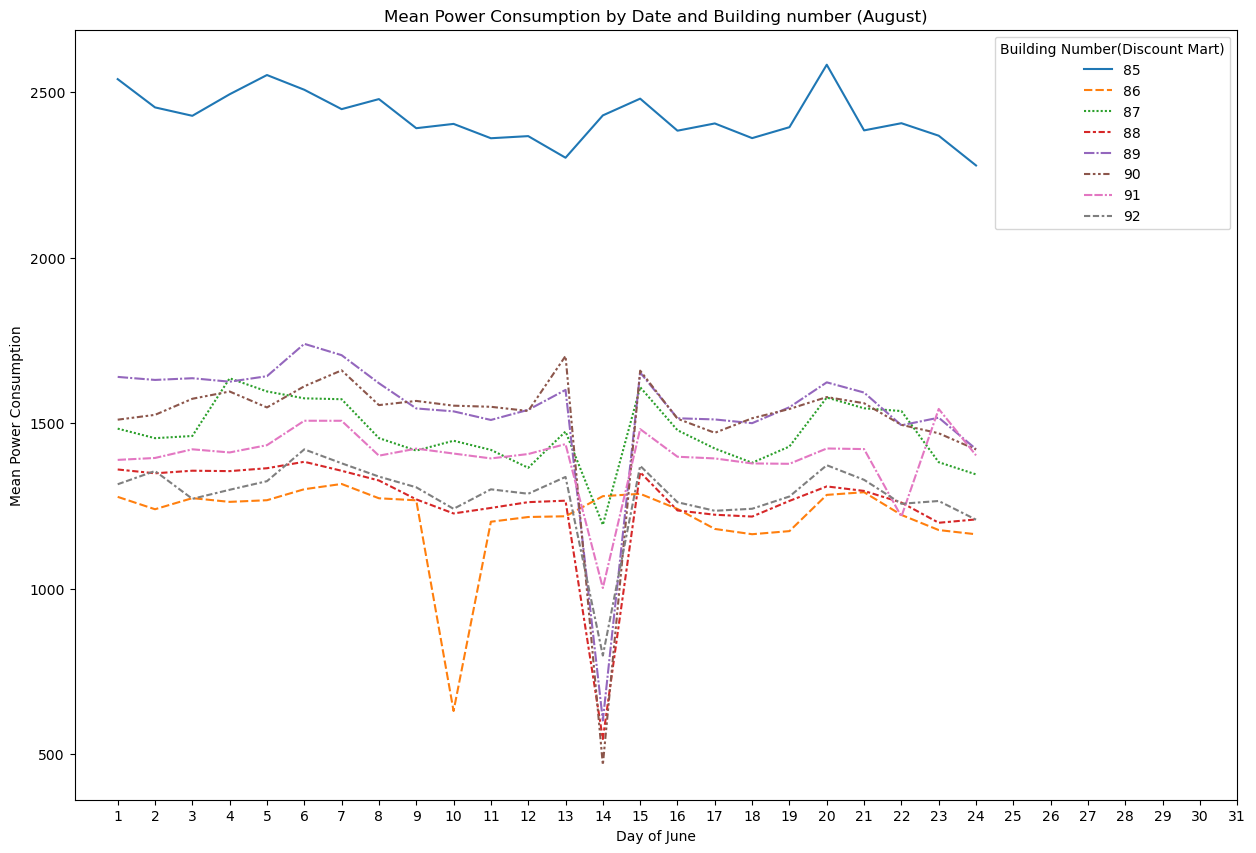

In [39]:
# Discount Mart (7월) 데이터
# 8월 데이터 추출
Aug_data = train_df[(train_df['month'] == 8) & (train_df['building_number'].between(85, 92))]


# 건물 타입별 날짜별 평균 전력 소비량 계산
mean_power_by_date_building_type = Aug_data.groupby(['day', 'building_number'])['power_consumption'].mean().reset_index()

# Pivot 테이블 생성
pivot_df = mean_power_by_date_building_type.pivot(index='day', columns='building_number', values='power_consumption')

# 그래프 그리기
plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Date and Building number (August)')
plt.xlabel('Day of June')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Number(Discount Mart)')
plt.xticks(range(1, 32))   # 8월은 31일까지 있으므로 범위를 1부터 31까지로 설정
plt.show()

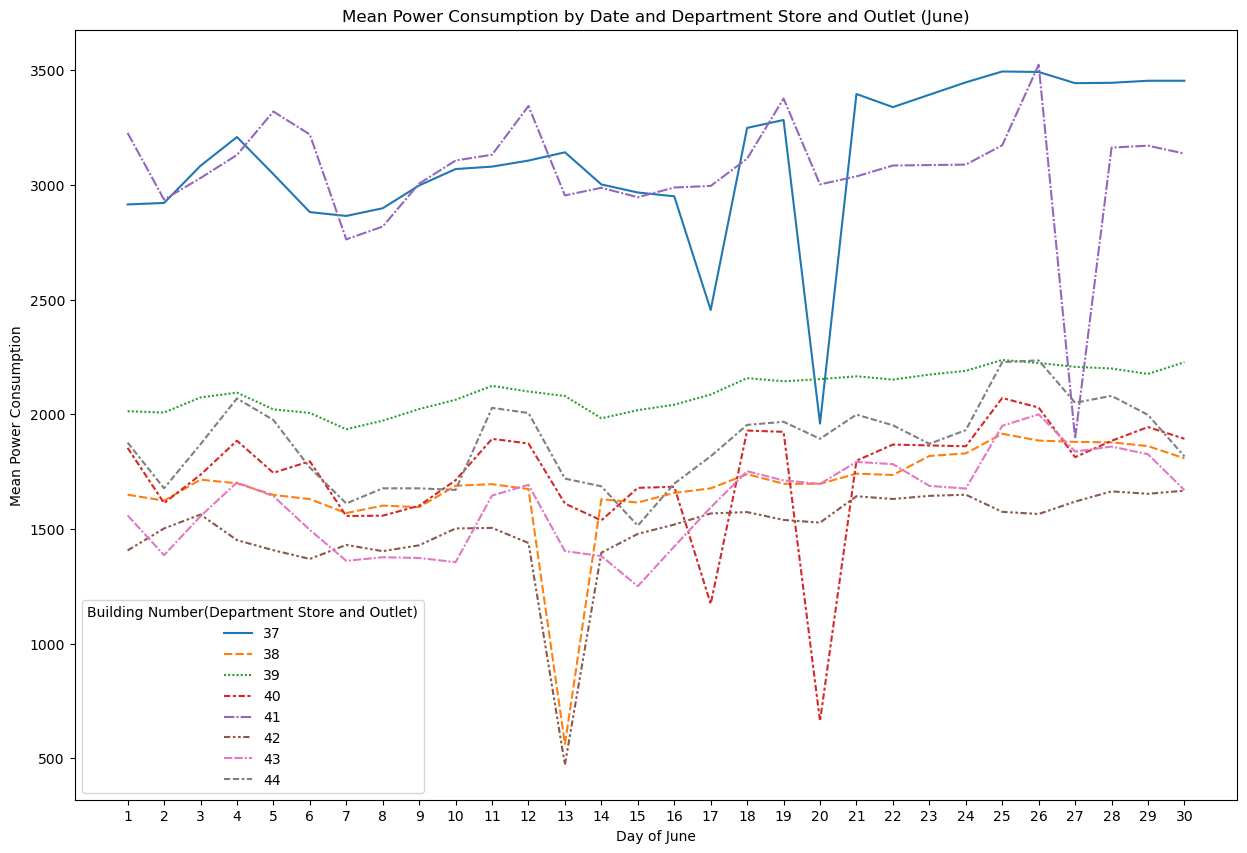

In [40]:
# Department Store and Outlet (6월) 데이터

# 필요한 데이터 추출 (6월 데이터)
june_data = train_df[(train_df['month'] == 6) & (train_df['building_number'].between(37, 44))]

# 건물 번호별 날짜별 평균 전력 소비량 계산
mean_power_by_date_building_number = june_data.groupby(['day', 'building_number'])['power_consumption'].mean().reset_index()

# Pivot 테이블 생성
pivot_df = mean_power_by_date_building_number.pivot(index='day', columns='building_number', values='power_consumption')

# 그래프 그리기
plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Date and Department Store and Outlet (June)')
plt.xlabel('Day of June')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Number(Department Store and Outlet)')
plt.xticks(range(1, 31))  # 6월은 30일까지 있으므로 범위를 1부터 30까지로 설정
plt.show()

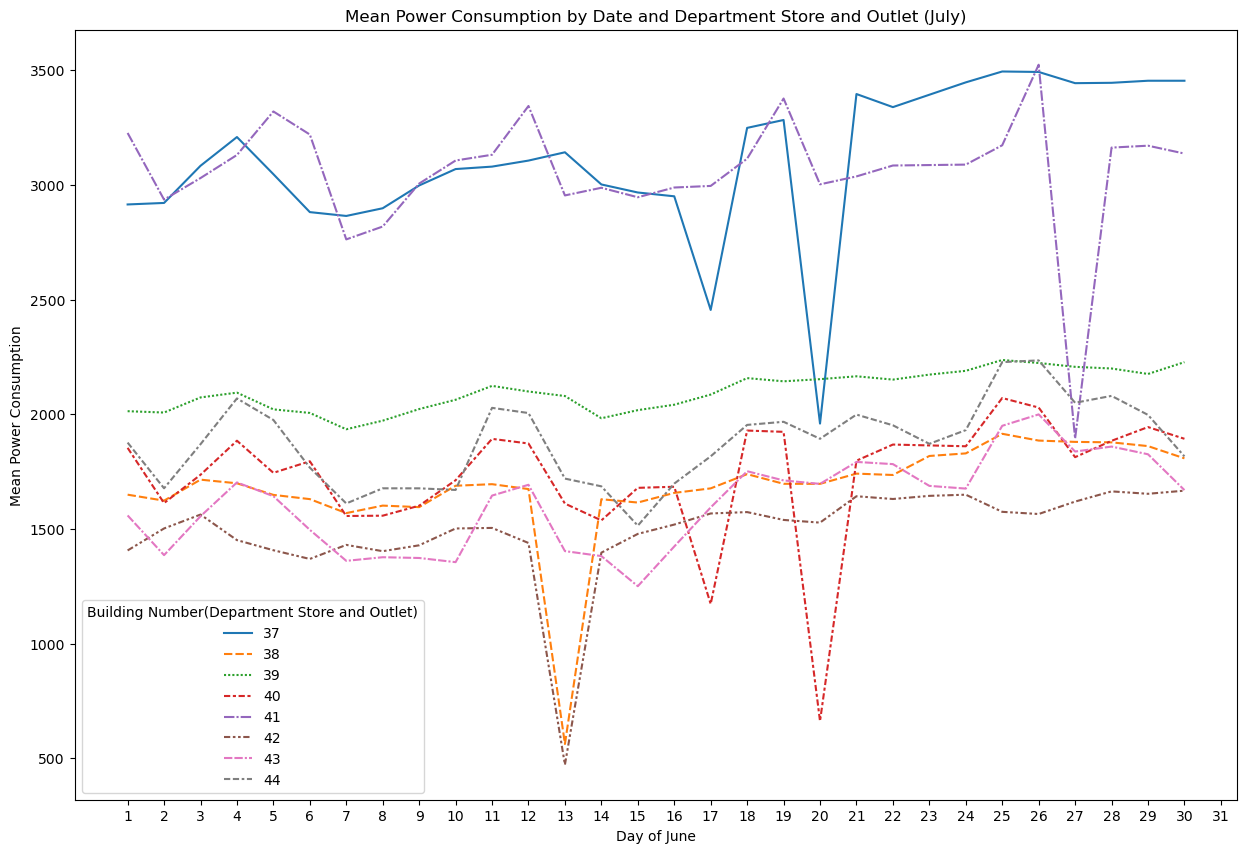

In [42]:
# Department Store and Outlet (7월) 데이터

# 필요한 데이터 추출 (7월 데이터)
July_data = train_df[(train_df['month'] == 7) & (train_df['building_number'].between(37, 44))]

# 건물 번호별 날짜별 평균 전력 소비량 계산
mean_power_by_date_building_number = june_data.groupby(['day', 'building_number'])['power_consumption'].mean().reset_index()

# Pivot 테이블 생성
pivot_df = mean_power_by_date_building_number.pivot(index='day', columns='building_number', values='power_consumption')

# 그래프 그리기
plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Date and Department Store and Outlet (July)')
plt.xlabel('Day of June')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Number(Department Store and Outlet)')
plt.xticks(range(1, 32))  # 7월은 31일까지 있으므로 범위를 1부터 30까지로 설정
plt.show()

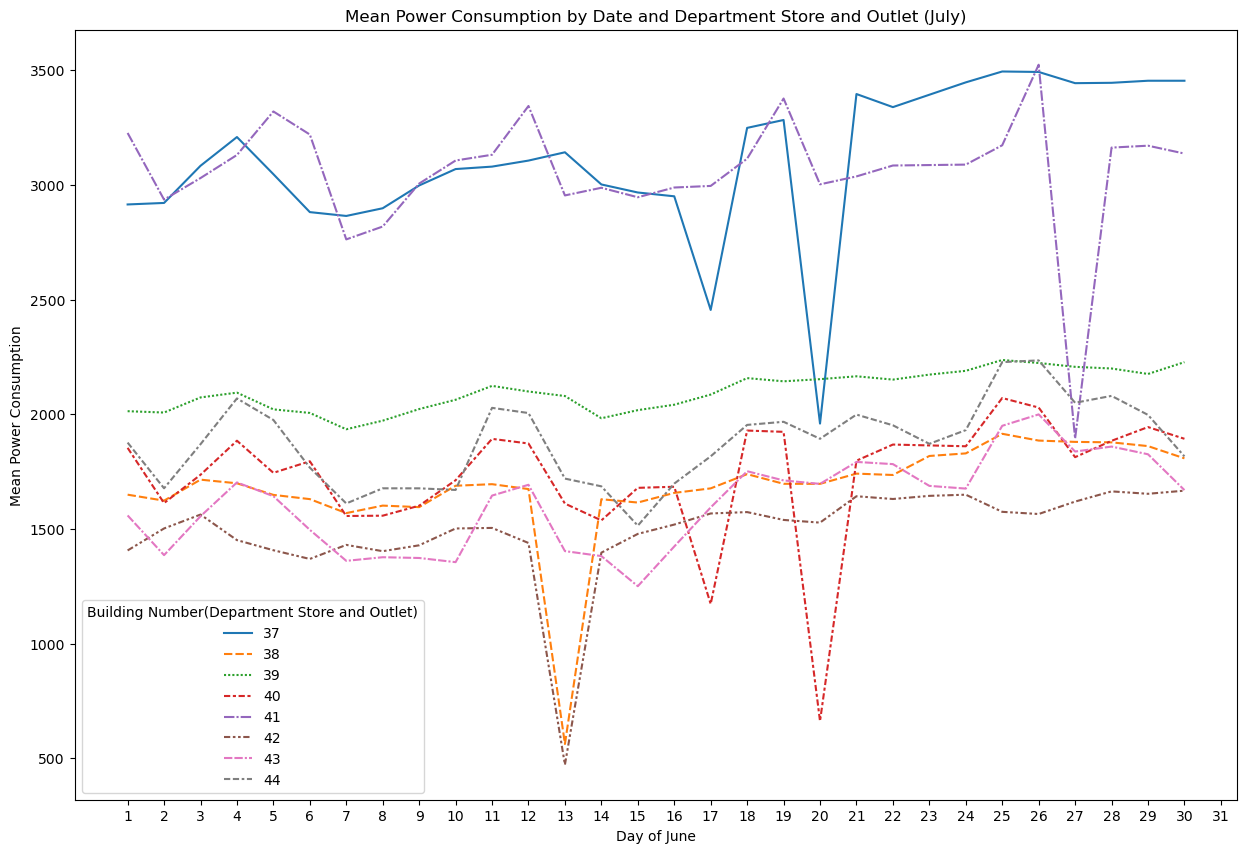

In [43]:
# Department Store and Outlet (8월) 데이터

# 필요한 데이터 추출 (8월 데이터)
July_data = train_df[(train_df['month'] == 8) & (train_df['building_number'].between(37, 44))]

# 건물 번호별 날짜별 평균 전력 소비량 계산
mean_power_by_date_building_number = june_data.groupby(['day', 'building_number'])['power_consumption'].mean().reset_index()

# Pivot 테이블 생성
pivot_df = mean_power_by_date_building_number.pivot(index='day', columns='building_number', values='power_consumption')

# 그래프 그리기
plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Date and Department Store and Outlet (July)')
plt.xlabel('Day of June')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Number(Department Store and Outlet)')
plt.xticks(range(1, 32))  # 8월은 31일까지 있으므로 범위를 1부터 30까지로 설정
plt.show()

```
power_mean = pd.pivot_table(train, values = 'target', index = ['building', 'hour', 'dow'], aggfunc = np.mean).reset_index()  
power_mean.rename(columns={'target': 'dow_hour_mean'}, inplace=True)  
train = pd.merge(train, power_mean, on=['building', 'hour', 'dow'], how='left')  
test = pd.merge(test, power_mean, on=['building', 'hour', 'dow'], how='left')  
```

[ 미션 3. ]
🎯 아래의 질문에 대한 답을 제출해 보아요

위의 코드에서 생성된 'dow_hour_mean'는 어떤 의미의 feature 인지, 'target'과는 무엇이 다른 feature인지 말로 표현해 보세요

'dow_hour_mean' feature를 생성함으로서 예측 모델 관점에서 기대할 수 있는 효과를 기술해 보세요

- `dow_hour_mean`: 요일('dow')과 시간('hour')과 건물('building')에 따른 평균 전력 소비량
- `target`: 해당 시간 대와 요일에 발생한 **실제** 전력 소비량
  > 2개 feature의 차이점은 dow_hour_mean는 평균값을 계산한 것
  
  - 기대효과
      - model이 각 건물에 대해 특정 시간대와 요일에 발생하는 전력 소비량의 평균을 학습할 수 있다.
      - 이를 통해 모델이 시간과 요일에 따른 전력 소비량의 경향성을 학습하고, 예측 시 해당 시간대와 요일의 전력소비량을 보다 정확하게 에측 가능하다